## Import required libraries

In [ ]:
import numpy as np
import tensorflow as tf
from spectral import open_image
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, BatchNormalization, Activation, Add, Concatenate, Input
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as compare_ssim
from skimage.metrics import structural_similarity as ssim

## Preprocess dataset with band grouping for scaling 4x

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define the path to the hyperspectral data
header_file = "HyperspecVNIR_Chikusei_20140729.hdr"

# Load the hyperspectral data
img = open_image(header_file)
data = img.load()

# Parameters
patch_size = (144, 144)  # Size of patches to extract
test_size = 0.2  # Proportion of data for testing
validation_size = 0.1  # Proportion of data for validation
downscale_factor = 4  # Factor to downscale patches
nodata_value = 15000.0  # Value that indicates "no data"
group_size = 6  # Group size for spectral bands
overlap_size = 2  # Overlap size for grouped bands

# Function to group bands into overlapping subgroups
def group_bands_with_overlap(data, group_size=6, overlap_size=2):
    height, width, bands = data.shape
    step_size = group_size - overlap_size  # Calculate step size based on overlap
    grouped_data = []

    # Create overlapping groups of bands
    for g in range(0, bands - group_size + 1, step_size):
        group = data[:, :, g:g + group_size]
        grouped_data.append(group)
    
    return np.array(grouped_data)

# Function to extract and downscale patches from hyperspectral data
def extract_and_downscale_patches(data, patch_size, downscale_factor, nodata_value=0):
    patches_hr = []
    patches_lr = []
    height, width, bands = data.shape

    for i in range(0, height - patch_size[0] + 1, patch_size[0]):
        for j in range(0, width - patch_size[1] + 1, patch_size[1]):
            patch_hr = data[i:i + patch_size[0], j:j + patch_size[1], :]

            # Check for nodata_value and skip patch extraction if present
            if np.any(patch_hr == nodata_value):
                continue
            
            patch_lr = tf.image.resize(patch_hr, 
                                       [patch_size[0] // downscale_factor, patch_size[1] // downscale_factor], 
                                       method='bilinear')
            patches_hr.append(patch_hr)
            patches_lr.append(patch_lr.numpy())  # Convert tensor to numpy

    return np.array(patches_hr), np.array(patches_lr)

# Group bands into overlapping subgroups
grouped_data = group_bands_with_overlap(data, group_size=group_size, overlap_size=overlap_size)

# Extract and downscale patches for all groups
all_patches_hr = []
all_patches_lr = []

for group in grouped_data:
    patches_hr, patches_lr = extract_and_downscale_patches(group, patch_size, downscale_factor, nodata_value=nodata_value)
    all_patches_hr.append(patches_hr)
    all_patches_lr.append(patches_lr)

# Concatenate patches from all groups
all_patches_hr = np.concatenate(all_patches_hr, axis=0)
all_patches_lr = np.concatenate(all_patches_lr, axis=0)

# Calculate the number of patches
num_patches = len(all_patches_hr)

# Calculate sizes for training, validation, and testing sets
train_size = int((1 - test_size - validation_size) * num_patches)
validation_size = int(validation_size * num_patches)
test_size = num_patches - (train_size + validation_size)  # Explicit calculation of test size

# Shuffle indices for splitting the data
indices = np.arange(num_patches)
np.random.shuffle(indices)
all_patches_hr = all_patches_hr[indices]
all_patches_lr = all_patches_lr[indices]

# Split into training, validation, and testing sets
X_train_hr, X_validation_hr, X_test_hr = np.split(all_patches_hr, [train_size, train_size + validation_size])
X_train_lr, X_validation_lr, X_test_lr = np.split(all_patches_lr, [train_size, train_size + validation_size])

# Print shapes to verify
print("X_train_hr shape:", X_train_hr.shape)
print("X_validation_hr shape:", X_validation_hr.shape)
print("X_test_hr shape:", X_test_hr.shape)

print("X_train_lr shape:", X_train_lr.shape)
print("X_validation_lr shape:", X_validation_lr.shape)
print("X_test_lr shape:", X_test_lr.shape)

I0000 00:00:1741287130.160229  931246 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:61:00.0, compute capability: 7.0


X_train_hr shape: (5902, 144, 144, 6)
X_validation_hr shape: (843, 144, 144, 6)
X_test_hr shape: (1687, 144, 144, 6)
X_train_lr shape: (5902, 36, 36, 6)
X_validation_lr shape: (843, 36, 36, 6)
X_test_lr shape: (1687, 36, 36, 6)


## Model development

In [3]:


# Spatial–Spectral Gradient Loss Function
def spatial_spectral_gradient_loss(y_true, y_pred):
    mse_loss = K.mean(K.square(y_true - y_pred))
    
    def spatial_gradient_loss(y_true, y_pred):
        grad_y_true_x = y_true[:, :, 1:, :] - y_true[:, :, :-1, :]
        grad_y_pred_x = y_pred[:, :, 1:, :] - y_pred[:, :, :-1, :]
        grad_y_true_y = y_true[:, 1:, :, :] - y_true[:, :-1, :, :]
        grad_y_pred_y = y_pred[:, 1:, :, :] - y_pred[:, :-1, :, :]
        
        loss_x = K.mean(K.square(grad_y_true_x - grad_y_pred_x))
        loss_y = K.mean(K.square(grad_y_true_y - grad_y_pred_y))
        
        return loss_x + loss_y

    def spectral_gradient_loss(y_true, y_pred):
        grad_y_true_spectral = y_true[:, :, :, 1:] - y_true[:, :, :, :-1]
        grad_y_pred_spectral = y_pred[:, :, :, 1:] - y_pred[:, :, :, :-1]
        return K.mean(K.square(grad_y_true_spectral - grad_y_pred_spectral))

    spatial_loss = spatial_gradient_loss(y_true, y_pred)
    spectral_loss = spectral_gradient_loss(y_true, y_pred)
    
    total_loss = mse_loss + 0.1 * spatial_loss + 0.1 * spectral_loss
    return total_loss

# Residual Block
def residual_block(x, filters=32):
    res = Conv2D(filters, (3, 3), padding='same')(x)
    res = BatchNormalization()(res)
    res = Activation('relu')(res)
    res = Conv2D(filters, (3, 3), padding='same')(res)
    res = BatchNormalization()(res)
    return Add()([x, res])

# Spectral–Spatial Block
def spectral_spatial_block(x, filters=32):
    spatial = Conv2D(filters, (3, 3), padding='same')(x)
    spatial = BatchNormalization()(spatial)
    spatial = Activation('relu')(spatial)
    
    spectral = Conv2D(filters, (1, 1), padding='same')(x)
    spectral = BatchNormalization()(spectral)
    spectral = Activation('relu')(spectral)
    
    spatial = Conv2D(filters, (1, 1), padding='same')(spatial)
    
    combined = Concatenate(axis=-1)([spatial, spectral])
    return combined

# Spectral Unmixing Block
def spectral_unmixing_block(x, num_endmembers=40):
    x = Conv2D(num_endmembers, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('softmax')(x)
    return x

# Upsampling Block 
def upsample_block(x, filters, scale=2, use_transpose=True):
    if use_transpose:
        x = Conv2DTranspose(filters, (3, 3), strides=(scale, scale), padding='same')(x)
    else:
        x = UpSampling2D(size=(scale, scale))(x)
        x = Conv2D(filters, (3, 3), padding='same')(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

# Build Model with Configurable Upsampling
def build_hybrid_sr_model(input_shape, num_endmembers=40, use_transpose=True):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(32, (9, 9), padding='same')(inputs)
    x = Activation('relu')(x)
    
    for _ in range(50):
        x = residual_block(x)
    
    x = spectral_spatial_block(x)
    
    x_unmixed = spectral_unmixing_block(x, num_endmembers)
    
    x_concat = Concatenate(axis=-1)([x, x_unmixed])
    
    x_up = upsample_block(x_concat, filters=64, scale=2, use_transpose=use_transpose)  # 2x upscaling
    x_up = upsample_block(x_up, filters=32, scale=2, use_transpose=use_transpose)  # 4x upscaling
    
    x_out = Conv2D(input_shape[-1], (3, 3), padding='same')(x_up)
    x_out = Activation('linear')(x_out)
    
    model = Model(inputs=inputs, outputs=x_out)
    return model

# Define input shape and build model
input_shape = (36, 36, 6)
num_endmembers = 40
use_transpose = True  

hybrid_sr_model = build_hybrid_sr_model(input_shape, num_endmembers=num_endmembers, use_transpose=use_transpose)

# Compile the model with the custom loss function
hybrid_sr_model.compile(optimizer='adam', loss=spatial_spectral_gradient_loss)

## Model training

Epoch 1/1000


I0000 00:00:1741287196.170531  931346 service.cc:148] XLA service 0x7f24d4001980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741287196.171391  931346 service.cc:156]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2025-03-06 20:53:17.770863: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741287203.224583  931346 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-03-06 20:53:29.472194: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[4,32,36,36]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,32,36,36]{3,2,1,0}, f32[32,32,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":

   3/1476 ━━━━━━━━━━━━━━━━━━━━ 38s 26ms/step - loss: 1.2803    

I0000 00:00:1741287223.395035  931346 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1473/1476 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0287

2025-03-06 20:54:24.769331: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[2,32,36,36]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,32,36,36]{3,2,1,0}, f32[32,32,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-03-06 20:54:24.895028: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[2,6,144,144]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,32,144,144]{3,2,1,0}, f32[6,32,3,3]{3,2,1,0}, f32[6]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationFo

1476/1476 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0287

2025-03-06 20:54:43.238397: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[3,32,36,36]{3,2,1,0}, u8[0]{0}) custom-call(f32[3,32,36,36]{3,2,1,0}, f32[32,32,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-03-06 20:54:43.353936: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[3,6,144,144]{3,2,1,0}, u8[0]{0}) custom-call(f32[3,32,144,144]{3,2,1,0}, f32[6,32,3,3]{3,2,1,0}, f32[6]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationFo

1476/1476 ━━━━━━━━━━━━━━━━━━━━ 132s 41ms/step - loss: 0.0287 - val_loss: 0.0020
Epoch 2/1000
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 34s 23ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 3/1000
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 34s 23ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 4/1000
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 34s 23ms/step - loss: 0.0016 - val_loss: 9.5334e-04
Epoch 5/1000
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 34s 23ms/step - loss: 0.0012 - val_loss: 9.0915e-04
Epoch 6/1000
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 34s 23ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 7/1000
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 34s 23ms/step - loss: 9.4258e-04 - val_loss: 7.9432e-04
Epoch 8/1000
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 34s 23ms/step - loss: 8.5968e-04 - val_loss: 7.0839e-04
Epoch 9/1000
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 35s 23ms/step - loss: 8.3530e-04 - val_loss: 6.8827e-04
Epoch 10/1000
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 34s 23ms/step - loss: 7.9018e-04 - val_loss: 6.6604e-04
Epoch 11/1000
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 34s 23

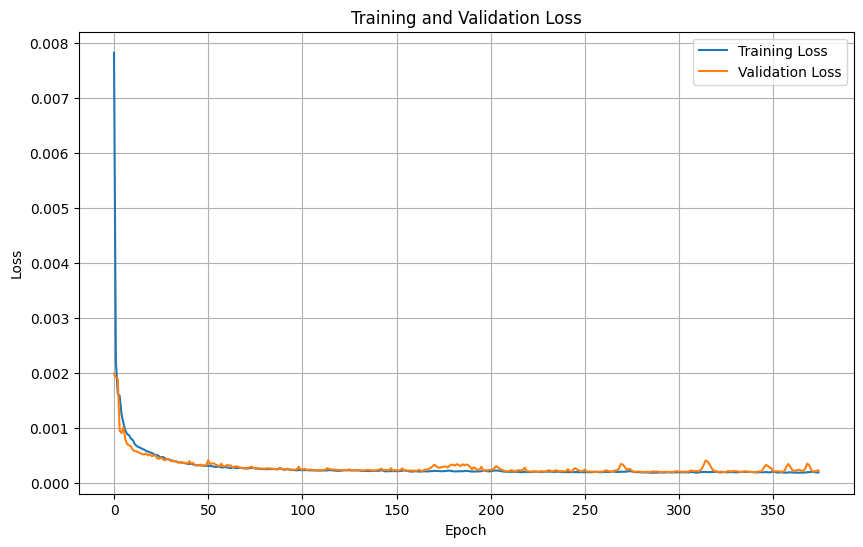

In [4]:
### # Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train the model and get the training history with early stopping
history = hybrid_sr_model.fit(
    X_train_lr, 
    X_train_hr, 
    epochs=1000, 
    batch_size=4, 
    validation_data=(X_validation_lr, X_validation_hr),
    callbacks=[early_stopping]  # Add the early stopping callback here
)

# Visualize training and validation loss over epochs
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True) 
plt.show()

## Report the results

In [5]:
# Function to calculate PSNR without normalization
def psnr(y_true, y_pred):
    max_pixel = np.max(y_true)  # Use the actual max value from y_true
    mse = np.mean((y_true - y_pred) ** 2)
    if mse == 0:  # Avoid log of zero
        return float('inf')
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

# Function to calculate SSIM with channel_axis
def ssim_value(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise ValueError(f"Shape mismatch: y_true shape {y_true.shape} vs y_pred shape {y_pred.shape}")
    
    data_range = y_true.max() - y_true.min()  # Calculate data range from y_true
    ssim_val = ssim(y_true, y_pred, data_range=data_range, channel_axis=-1)
    return ssim_val

# Function to calculate Correlation Coefficient
def correlation_coefficient(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    corr_matrix = np.corrcoef(y_true_flat, y_pred_flat)
    corr_value = corr_matrix[0, 1]
    return corr_value

# Function to calculate Spectral Angle Mapper (SAM) in degrees
def sam(y_true, y_pred):
    y_true_reshaped = y_true.reshape(-1, y_true.shape[-1])
    y_pred_reshaped = y_pred.reshape(-1, y_pred.shape[-1])
    
    non_zero_mask = (np.linalg.norm(y_true_reshaped, axis=1) > 1e-10) & (np.linalg.norm(y_pred_reshaped, axis=1) > 1e-10)
    dot_product = np.sum(y_true_reshaped[non_zero_mask] * y_pred_reshaped[non_zero_mask], axis=1)
    norm_true = np.linalg.norm(y_true_reshaped[non_zero_mask], axis=1)
    norm_pred = np.linalg.norm(y_pred_reshaped[non_zero_mask], axis=1)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        angles = np.arccos(np.clip(dot_product / (norm_true * norm_pred), -1.0, 1.0))
    
    if angles.size > 0:
        sam_value_degrees = np.mean(angles) * (180 / np.pi)
    else:
        sam_value_degrees = 0
    
    return sam_value_degrees

# Function to normalize the images
def normalize(image):
    min_val = np.min(image)
    max_val = np.max(image)
    return (image - min_val) / (max_val - min_val)  # Normalize to [0, 1]

# Function to calculate Root Mean Squared Error (RMSE) for hyperspectral images (normalized)
def rmse_bandwise(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise ValueError("Shape mismatch between true and predicted images.")
    
    bands = y_true.shape[-1]
    rmse_per_band = []

    for b in range(bands):
        band_true = y_true[:, :, b]
        band_pred = y_pred[:, :, b]
        
        mse_band = np.mean((band_true - band_pred) ** 2)
        rmse_band_value = np.sqrt(mse_band)
        rmse_per_band.append(rmse_band_value)

    # Normalize RMSE by the maximum value in y_true across all bands
    max_value = np.max(y_true)
    normalized_rmse = np.mean(rmse_per_band) / max_value
    return normalized_rmse

# Function to calculate ERGAS
def ergas(y_true, y_pred, scale):
    bands = y_true.shape[-1]
    ergas_value = 0
    
    for b in range(bands):
        band_true = y_true[:, :, b]
        band_pred = y_pred[:, :, b]
        mean_band_true = np.mean(band_true)
        
        # Calculate RMSE for the band without using a separate function
        mse_band = np.mean((band_true - band_pred) ** 2)  # Mean Squared Error for the band
        rmse_band = np.sqrt(mse_band)  # Root Mean Squared Error for the band
        
        ergas_value += (rmse_band / mean_band_true) ** 2
    
    ergas_value = 100 * (1 / scale) * np.sqrt(ergas_value / bands)
    return ergas_value

# Assuming hybrid_sr_model is trained, and X_test_lr, X_test_hr are defined
predicted_hr_images = hybrid_sr_model.predict(X_test_lr)
downscale_factor = 4  # ERGAS downscale factor

# Validate shapes match for test and predictions
if predicted_hr_images.shape != X_test_hr.shape:
    raise ValueError(f"Shape mismatch: predicted_hr_images shape {predicted_hr_images.shape} vs X_test_hr shape {X_test_hr.shape}")

# Calculate metrics per test sample
psnr_values, ssim_values, cc_values, sam_values, ergas_values, rmse_values = [], [], [], [], [], []

for i in range(len(X_test_hr)):
    psnr_values.append(psnr(X_test_hr[i], predicted_hr_images[i]))
    ssim_values.append(ssim_value(X_test_hr[i], predicted_hr_images[i]))
    cc_values.append(correlation_coefficient(X_test_hr[i], predicted_hr_images[i]))
    sam_values.append(sam(X_test_hr[i], predicted_hr_images[i]))
    ergas_values.append(ergas(X_test_hr[i], predicted_hr_images[i], downscale_factor))
    rmse_values.append(rmse_bandwise(X_test_hr[i], predicted_hr_images[i]))

# Average metrics
average_psnr = np.mean(psnr_values)
average_ssim = np.mean(ssim_values)
average_cc = np.mean(cc_values)
average_sam = np.mean(sam_values)
average_ergas = np.mean(ergas_values)
average_rmse = np.mean(rmse_values)

# Print the evaluation metrics
print("Average PSNR on the test set:", average_psnr)
print("Average SSIM on the test set:", average_ssim)
print("Average SAM on the test set (in degrees):", average_sam)
print("Average Correlation Coefficient on the test set:", average_cc)
print("Average ERGAS on the test set:", average_ergas)
print("Average RMSE:", average_rmse)  # Indicate RMSE is normalized

2025-03-07 00:29:15.184655: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,32,36,36]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,36,36]{3,2,1,0}, f32[32,32,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-03-07 00:29:15.392742: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,6,144,144]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,144,144]{3,2,1,0}, f32[6,32,3,3]{3,2,1,0}, f32[6]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivati

49/53 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

2025-03-07 00:29:19.929462: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[23,32,36,36]{3,2,1,0}, u8[0]{0}) custom-call(f32[23,32,36,36]{3,2,1,0}, f32[32,32,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-03-07 00:29:20.096454: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[23,6,144,144]{3,2,1,0}, u8[0]{0}) custom-call(f32[23,32,144,144]{3,2,1,0}, f32[6,32,3,3]{3,2,1,0}, f32[6]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivati

53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step
Average PSNR on the test set: 31.559786665135753
Average SSIM on the test set: 0.8809812
Average SAM on the test set (in degrees): 2.266616647938358
Average Correlation Coefficient on the test set: 0.9633994058465039
Average ERGAS on the test set: 3.8812210535120037
Average RMSE: 0.027451795
